## Week 6 Class activities
This notebook is a starting point for the exercises and activities that we'll do in class. We'll do an extension of the random forests classifier, looking at a continuous variable. Then, we'll do some cluster analysis.

Before you attempt any of these activities, make sure to watch the video lectures for this week.

### Classification: NYC evictions
We'll look at the factors that are associated with evictions in New York City. Perhaps a machine learning model can identify the types of places that are vulnerable to eviction, and target renter assistance programs more effectively?

#### Loading in the data

Let's start by loading in the [eviction dataset](https://data.cityofnewyork.us/City-Government/Evictions/6z8x-wfk4) via Socrata.

<div class="alert alert-block alert-info">

<strong>Exercise:</strong> Import the data from Socrata via the API into a pandas DataFrame.
</div>

*Hints*:
- Look back at Week 1 if you need a refresher on using Socrata
- There are about 70,000 rows in the dataset. So remember to add `?$limit=100000` to the end of the URL that you pass to `requests.get()`. Otherwise, you'll just get the first 1,000 rows. (The limit can be anything comfortably above 70000.)

In [25]:
import requests
import json
import pandas as pd
import geopandas as gpd


requestString = 'https://data.cityofnewyork.us/resource/6z8x-wfk4.json?$limit=100'
r = requests.get(requestString)
d = json.loads(r.text)
#etd = d['root']['station'][0]['etd']
#print('Trains from {} to {}'.format(station, etd[0]['destination']))
df = pd.DataFrame(d)
#df# your code here
print(df.columns)

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apt_num', 'executed_date', 'marshal_first_name',
       'marshal_last_name', 'residential_commercial_ind', 'borough',
       'eviction_zip', 'ejectment', 'eviction_possession', 'latitude',
       'longitude', 'community_board', 'council_district', 'census_tract',
       'bin', 'bbl', 'nta'],
      dtype='object')


<div class="alert alert-block alert-info">

<strong>Exercise:</strong> Convert your dataframe to a GeoDataFrame, using the latitude and longitude columns.

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apt_num', 'executed_date', 'marshal_first_name',
       'marshal_last_name', 'residential_commercial_ind', 'borough',
       'eviction_zip', 'ejectment', 'eviction_possession', 'latitude',
       'longitude', 'community_board', 'council_district', 'census_tract',
       'bin', 'bbl', 'nta', 'geometry'],
      dtype='object')


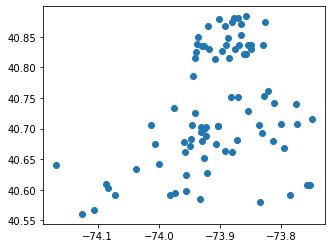

In [26]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.plot()
print(gdf.columns)

Now let's import some census data. We could use `cenpy` or the Census Bureau API. But to keep things simple so that we can focus on the spatial joins and the machine learning, I downloaded the block group-level 2019 ACS data for New York from the [Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-data.html). To save space, I clipped it to the 5 NYC counties.

It's in your repository, and we can load it in as follows. If you aren't familiar with a GeoPackage (GPKG) format, think of it as a "new and improved shapefile." [Here's a good overview.](https://towardsdatascience.com/why-you-need-to-use-geopackage-files-instead-of-shapefile-or-geojson-7cb24fe56416)

In [27]:
bgs = gpd.read_file('data/nyc_bgs.gpkg')
bgs.head()

/opt/anaconda3/envs/urbandatascience/lib/python3.8/site-packages/geopandas/geodataframe.py:600: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,GEOID,B01001e1,B01001e10,B01001e11,B01001e12,B01001e13,B01001e14,B01001e15,B01001e16,B01001e17,...,B19001e8,B19001e9,B22010e1,B22010e2,B22010e3,B22010e4,B22010e5,B22010e6,B22010e7,geometry
0,15000US360050175002,656,39,0,0,0,18,14,0,22,...,11,0,358,214,139,75,144,107,37,"POLYGON ((-73.91570 40.83054, -73.91485 40.830..."
1,15000US360050141001,1228,0,35,96,26,45,28,0,54,...,34,0,503,291,226,65,212,70,142,"POLYGON ((-73.91661 40.82499, -73.91592 40.825..."
2,15000US360050145001,2716,44,192,33,38,76,30,64,93,...,137,83,972,534,316,218,438,7,431,"POLYGON ((-73.90584 40.83106, -73.90505 40.832..."
3,15000US360050075002,3488,43,109,122,169,19,51,139,22,...,63,37,1188,470,300,170,718,147,571,"POLYGON ((-73.91035 40.81995, -73.91022 40.820..."
4,15000US360050418001,657,0,38,5,11,21,14,43,25,...,0,0,217,87,18,69,130,41,89,"POLYGON ((-73.86288 40.89515, -73.86146 40.897..."


Note that the variables aren't particularly carefully selected - I just threw in many of the demographic and housing variables. 

Nor are the variable names particularly informative, but the full names are in a file in the repository.

In [28]:
# note it is tab-sepated, not comma separated
# so we use the sep='\t' argument

col_names = pd.read_csv('data/BG_METADATA_2019.txt', sep='\t', index_col='Short_Name')
col_names.head()

,Full_Name
Short_Name,
B01001e1,SEX BY AGE: Total: Total population -- (Estimate)
B01001m1,SEX BY AGE: Total: Total population -- (Margin...
B01001e2,SEX BY AGE: Male: Total population -- (Estimate)
B01001m2,SEX BY AGE: Male: Total population -- (Margin ...
B01001e3,SEX BY AGE: Male: Under 5 years: Total populat...


So you can see the definition of the column like this. (I don't recommend renaming the `bg` column names, because the full names are so long.)

In [29]:
col_names.loc['B01001e1']

Full_Name    SEX BY AGE: Total: Total population -- (Estimate)
Name: B01001e1, dtype: object

#### Spatial join
Now let's do the spatial join. Again, let's follow our three step process.

1. Use a spatial join to add the `GEOID` column to the evictions dataframe. *Hint:* Check your projections.
2. Group by `GEOID` to get a count of evictions per block group. If you have a `Series`, give it a name - maybe `n_evictions`
3. Join those counts back - a tabular join based on the index

<div class="alert alert-block alert-info">
    <strong>Exercise:</strong> Add a count of evictions per census block group to your <strong>bgs</strong> GeoDataFrame, using the 3-step process above.
</div>

In [43]:

#bgs.set_index('GEOID', inplace=True)
#joinedDf = gdf.join(bgs.drop(columns='geometry')) 
#joinedDf.head()
bgs.to_crs('EPSG:3857', inplace= True)


gdf_sjoin = gpd.sjoin(gdf,bgs, predicate='intersects')

gdf_sjoin()

/var/folders/92/rtv_zgdd60n1wd_0q65qz2b40000gn/T/ipykernel_2713/3616697312.py:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:3857

  gdf_sjoin = gpd.sjoin(gdf,bgs, predicate='intersects')


RTreeError: Coordinates must not have minimums more than maximums

In [31]:
n_evictions = gpd.sjoin.groupby(by='GEOID').size() #.count

KeyError: 'GEOID'

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Do a quick-and-dirty map of the number of evictions. This will help identify any data holes.
</div>

ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

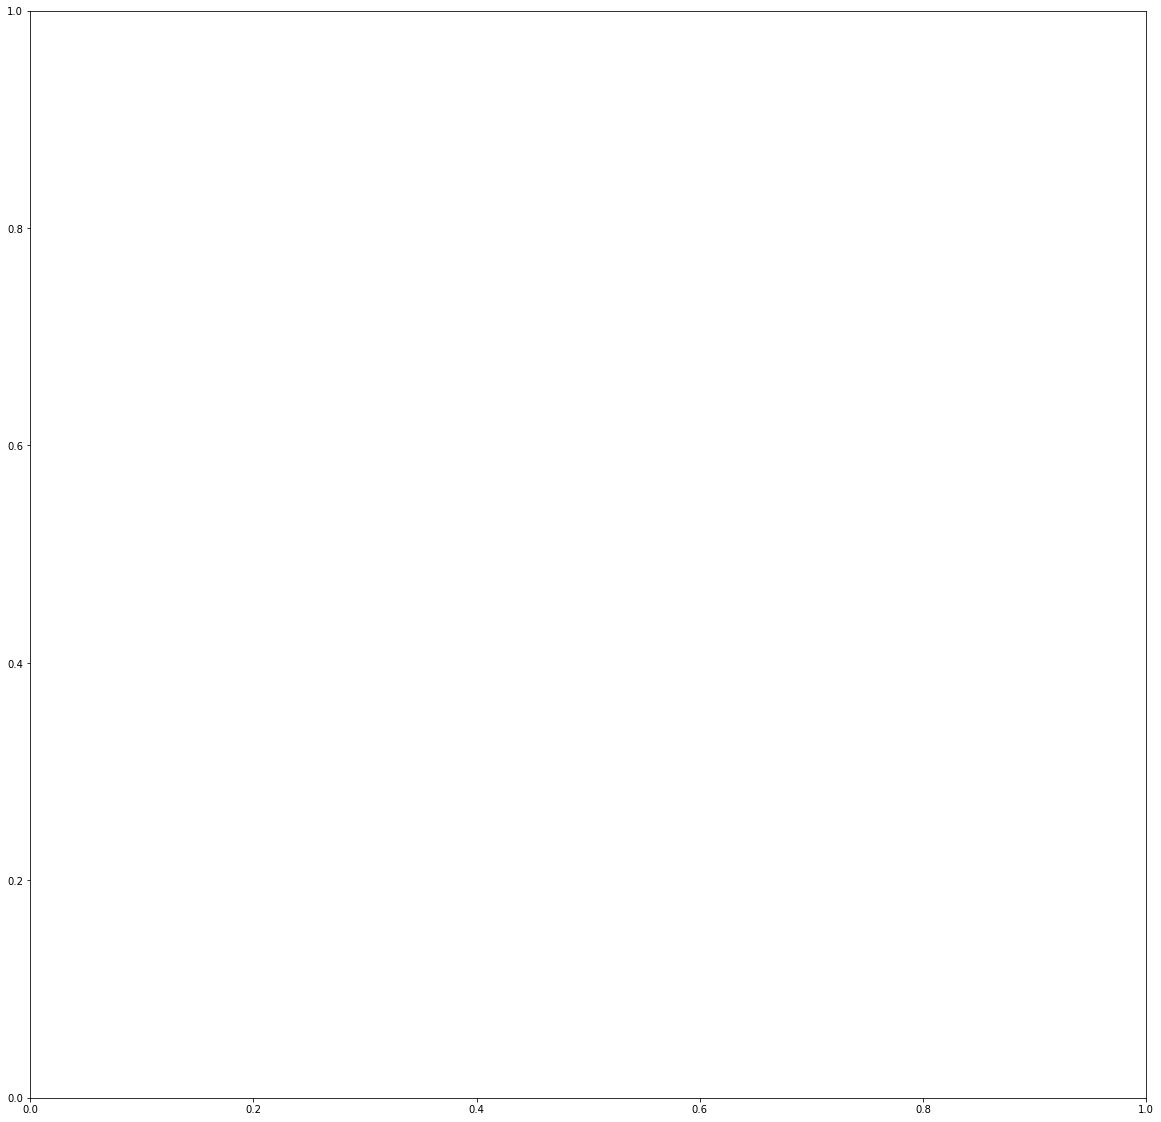

In [14]:
import contextily as ctx
import matplotlib.pyplot as plt

# Create blank figure and axes objects
fig, ax = plt.subplots(figsize=(20,20))
# Plot the data. ax=ax means we plot it on the axes that we just created
gdf.to_crs('EPSG:3857').plot(color='r', ax=ax) 

# Let's add a basemap using the contextily library
# Note that we add it to the same axes object. 
# The zoom level is trial and error
ctx.add_basemap(ax, zoom=12)

# and we really don't need the axis ticks and labels, so we set them to an empty list
ax.set_xticks([])
ax.set_yticks([])

#### Random forests regressor
Now we have our data set. Let's estimate a random forests model.

In contrast to the previous examples, we are trying to predict a continuous variable - the number of evictions. So our classifier isn't appropriate. 

However, there is a similar model: the [random forest regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor). It works almost identically to the classifier. The main difference from a user perspective is assessing model performance - a confusion matrix doesn't work here.

You'll need to follow the following steps:
- choose your x variables. (Your y variable will be `n_evictions`)
- Drop Null values if needed
- split your dataset into training and testing portions
- estimate (fit) the model

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Estimate a random forest regressor model to predict the number of evictions per census tract.</div>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# your code here

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Assess the fit of your model.</div>

Remember, the confusion matrix and accuracy scores don't apply here. Some ideas for continuous variables are [here](https://stackoverflow.com/questions/50789508/random-forest-regression-how-do-i-analyse-its-performance-python-sklearn). You could also plot actual vs predicted values.

In [ ]:
# your code here

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Which variables are most important in your predictions? Plot the forest importances.</div>

In [ ]:
# your code here


## Clustering
We'll now look at some k-means cluster analysis. The question: are there particular patterns of cruising for parking? You can see [my version of the analysis here](https://findingspress.org/article/28061-the-shape-of-cruising), joint with Robert Hampshire and Rachel Weinberger.

The data file that replicate the analysis is in your data folder. There is one row for each cruising trip (derived from the final portion of a GPS trace, once a driver is assumed to start looking for parking.)

You can load the data as follows.

In [ ]:
import pandas as pd
cruisingDf = pd.read_csv('data/cruising_shapes.csv')

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Replicate the analysis in Millard-Ball, Hampshire and Weinberger (2021). First, add each cluster label to the dataframe.</div>

In the paper, we used 5 clusters and the following columns: `'matchdist', 'frc_repeat', 'n_crossings', 'convexhull_ratio', 'frc_right', 'frc_left', 'frc_uturn', 'frc_straight', 'n_turns'`

* `matchdist` is path length (technically, the map-matched distance)
* `frc_repeat` is the fraction of repeated blocks (a driver drives on them more than once while cruising for parking)
* `n_crossings` is the number of times that the driver crosses over their path
* `convexhull_ratio` is a measure of the compactness of the search area
* `frc_right`, `frc_left`, `frc_uturn` and `frc_straight` are the fraction of times that the driver turns right or left, makes a U-turn, or continues straight at an intersection
* `n_turns` is the number of turns in the cruising trace

You'll need to:
* standardize the variables
* drop Null values
* run the k-means algorithm
* add the cluster labels back to your dataframe

How many observations do you get in each cluster?

In [ ]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

# your code here

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Create a radar plot of your clusters.</div>

Here's the function to create the radar chart, which we used in the video lecture.

It takes two arguments: the `kmeans` object created by `KMeans`, and your standardized dataframe.

In [ ]:
# this cell defines the radar_plot() function that we used in lecture
# no need to change anything here. Add your code in the cell below

# code from https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

def radar_plot(kmeans, df_scaled):
    N  = kmeans.cluster_centers_.shape[1]  # number of columns / variables
    k = kmeans.n_clusters
    theta = radar_factory(N, frame='polygon')
    data = kmeans.cluster_centers_.T
    spoke_labels = [col for col in df_scaled.columns if col!='cluster_id']
    fig, ax = plt.subplots(figsize=(9, 9),
                                subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    ax.plot(theta, data) #, color=color)
    ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ['Cluster {}'.format(kk) for kk in range(k)]
    ax.legend(labels, loc=(0.9, .95),
                                labelspacing=0.1, fontsize='small')
    


In [ ]:
# your code here

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Experiment with different values of k (number of clusters), and using different columns.</div>

In [ ]:
# your code here

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> The dataframe comes with x and y coordinates. Use them to identify any spatial clusters of cruising trips in San Francisco.</div>

In [ ]:
# your code here

<div class="alert alert-block alert-info">
<h3>What you should have learned</h3>
<ul>
  <li>Get more practice with spatial joins and Socrata.</li>
  <li>Learn how to estimate a random forests model for continuous data.</li>
  <li>Get more practice with standardizing data.</li>
  <li>Learn how to estimate a k-means cluster analysis.</li>
</ul>
</div>